## Import libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

## Import Raw Data

In [2]:
orig_dir = os.getcwd()
os.chdir(orig_dir)

bridges_dataset = pd.read_excel('raw_data/BMMS_overview.xlsx')
roads_dataset = pd.read_csv('raw_data/_roads3.csv')
widths_dataset = pd.concat([pd.read_csv("raw_data/road_widths/" + r + ".widths.processed.txt", sep="\t")
                                  for r in roads_dataset.road.unique()])

traffic_dataset = pd.concat([pd.read_html("raw_data/road_traffic/" + r + ".traffic.htm")[4].iloc[3:].reset_index(drop=True)
                                  for r in roads_dataset.road.unique()]).reset_index(drop=True)
traffic_num_cols = ["Heavy Truck","Medium Truck","Small Truck","Large Bus","Medium Bus", "Micro Bus","Utility",
            "Car","Auto Rickshaw","Motor Cycle","Bi-Cycle","Cycle Rickshaw",
            "Cart","Motorized","Non Motorized","AADT"]
traffic_dataset.columns = ["Link","Name","startLRP","startOffset","startChainage","endLRP","endOffset",
                           "endChainage","Km"] + traffic_num_cols + ["Total AADT"]
traffic_dataset["road"] = traffic_dataset["Link"].str.split(pat="-", n=2, expand=True)[0]
traffic_dataset["segmentNo"] = traffic_dataset["Link"].str.split(pat="-", n=2, expand=True)[1].map(lambda x: x.rstrip('lLRr'))
traffic_dataset[traffic_num_cols+["Km", "startChainage", "endChainage", "segmentNo"]] = traffic_dataset[traffic_num_cols+["Km", "startChainage", "endChainage", "segmentNo"]].apply(pd.to_numeric, errors='coerce')

## Cleaning Data

In [3]:
df_bridges = bridges_dataset.sort_values(by=['road', 'chainage']).drop_duplicates(subset =['road', 'chainage'], keep='first').reset_index(drop=True)

df_roads = roads_dataset.sort_values(by=['road', 'chainage']).drop_duplicates(subset =['road', 'chainage'], keep='first').reset_index(drop=True)

df_widths = widths_dataset.sort_values(by=['roadNo', 'startChainage']).drop_duplicates(subset =['roadNo', 'startChainage'], keep='first').reset_index(drop=True)
df_widths.columns = ["road", "roadId", "startChainage", "endChainage", "width", "nrLanes"]

df_traffic = traffic_dataset.drop_duplicates(subset =['road', 'segmentNo'], keep='first').sort_values(by=['road', 'startChainage']).reset_index(drop=True)
df_traffic_grouped = df_traffic.groupby(['road', 'startChainage'])[traffic_num_cols].sum().reset_index()
df_traffic_rem = df_traffic.drop_duplicates(subset =['road', 'startChainage'], keep='first').reset_index(drop=True)
df_traffic_grouped[["segmentNo","Name","startLRP","startOffset","endLRP","endOffset","endChainage","Km"]] = df_traffic_rem[["segmentNo","Name","startLRP","startOffset","endLRP","endOffset","endChainage","Km"]]

common_road_list = sorted(list(set(df_traffic_grouped.road.unique().tolist())
      &set(df_widths.road.unique().tolist())
      &set(df_roads.road.unique().tolist())
      &set(df_bridges.road.unique().tolist())))
df_bridges_filtered = df_bridges[df_bridges.road.isin(common_road_list)].reset_index(drop=True)
df_roads_filtered = df_roads[df_roads.road.isin(common_road_list)].reset_index(drop=True)
df_widths_filtered = df_widths[df_widths.road.isin(common_road_list)].reset_index(drop=True)
df_traffic_filtered = df_traffic_grouped[df_traffic_grouped.road.isin(common_road_list)].reset_index(drop=True)

## Exploring Data

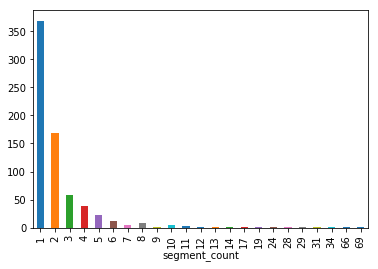

In [4]:
road_segment_count_traffic = df_traffic_filtered.groupby('road')["AADT", "startChainage"].count()
road_segment_count_traffic.columns = ["chainCount", "segment_count"]
road_segment_dist_traffic = road_segment_count_traffic.groupby('segment_count')['segment_count'].count()
road_segment_count_traffic = road_segment_count_traffic['segment_count']
road_segment_dist_traffic.plot(kind='bar')

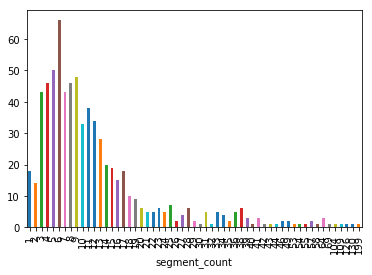

In [5]:
road_segment_count_widths = df_widths_filtered.groupby('road')["road", "width"].count()
road_segment_count_widths.columns = ["chainCount", "segment_count"]
road_segment_dist_widths = road_segment_count_widths.groupby('segment_count')['segment_count'].count()
road_segment_count_widths = road_segment_count_widths['segment_count']
road_segment_dist_widths.plot(kind='bar')

## Transforming Data

In [6]:
df_roads_transformed = pd.merge_ordered(df_roads_filtered[["road", "chainage", "lat", "lon"]], 
                                        df_traffic_filtered[["road", "startChainage", "segmentNo"]],
                                        left_on=["road", "chainage"],
                                        right_on=["road", "startChainage"],
                                        fill_method="ffill",
                                        how='outer')[["road", "segmentNo", "chainage", "lat", "lon"]]

In [7]:
print(df_roads_transformed.head())

  road  segmentNo  chainage        lat        lon
0   N1          1     0.000  23.706028  90.443333
1   N1          1     0.814  23.702917  90.450417
2   N1          2     0.822  23.702778  90.450472
3   N1          2     1.000  23.702139  90.451972
4   N1          2     2.000  23.697889  90.460583


In [8]:
addnl_coords = df_roads_transformed.drop_duplicates(subset=['road', 'segmentNo'], keep = 'first').reset_index(drop=True)
addnl_coords = addnl_coords[addnl_coords.segmentNo>1]
addnl_coords.segmentNo -= 1
df_roads_transformed = df_roads_transformed.append(addnl_coords).sort_values(by=['road', 'segmentNo', 'chainage']).reset_index(drop= True)

In [9]:
df_widths_transformed = pd.merge_ordered(df_widths_filtered[["road", "startChainage", "endChainage", "width", "nrLanes"]], 
                 df_traffic_filtered[["road", "startChainage", "segmentNo"]],
                 left_on=["road", "startChainage"],
                 right_on=["road", "startChainage"],
                 fill_method="ffill", how='outer')[["road", "segmentNo", "startChainage", "endChainage", "width", "nrLanes"]]
for i in range(len(df_widths_transformed) - 1):
    if(df_widths_transformed.loc[i, 'road'] == df_widths_transformed.loc[i+1, 'road']):
        df_widths_transformed.loc[i, 'endChainage'] = df_widths_transformed.loc[i+1, 'startChainage']
df_widths_transformed['Km'] = df_widths_transformed['endChainage']-df_widths_transformed['startChainage']

  road  segmentNo  startChainage  endChainage  width  nrLanes     Km
0   N1          1          0.000        0.130   29.7      8.0  0.130
1   N1          1          0.130        0.400   14.0      4.0  0.270
2   N1          1          0.400        0.822   28.3      8.0  0.422
3   N1          2          0.822        1.050   28.3      8.0  0.228
4   N1          2          1.050        4.175   16.5      5.0  3.125


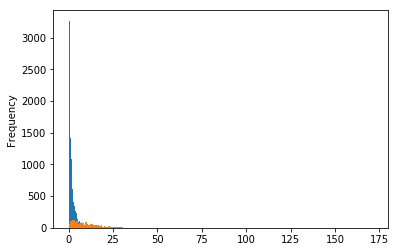

In [10]:
print(df_widths_transformed.head())
df_widths_transformed.Km.plot(kind='hist', bins=200)
df_traffic_filtered.Km.plot(kind='hist', bins=200)

In [11]:
df_widths_aggregated = df_widths_transformed[["road", "segmentNo", "width", "nrLanes", "Km"]]
df_widths_aggregated['mul_width'] = df_widths_aggregated['Km'] * df_widths_aggregated['width']
df_widths_aggregated['mul_nrLanes'] = df_widths_aggregated['Km'] * df_widths_aggregated['nrLanes']
df_widths_aggregated = df_widths_aggregated.groupby(['road', 'segmentNo'])[['Km', 'mul_width', 'mul_nrLanes']].sum().reset_index()
df_widths_aggregated['width'] = df_widths_aggregated['mul_width'] / df_widths_aggregated['Km']
df_widths_aggregated['nrLanes'] = df_widths_aggregated['mul_nrLanes'] / df_widths_aggregated['Km']
df_widths_aggregated = df_widths_aggregated[["road", "segmentNo", "width", "nrLanes", "Km"]]

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [12]:
print(df_widths_aggregated.head())

  road  segmentNo      width   nrLanes     Km
0   N1          1  23.824331  6.686131  0.822
1   N1          2  17.302386  5.203996  3.353
2   N1          3  17.195110  5.290419  3.006
3   N1          4  20.665424  5.817952  1.582
4   N1          5  16.171541  4.398361  3.173


In [13]:
df_bridges_transformed = df_bridges_filtered[["road", "chainage", "lat", "lon", 
                                              "type", "name", "LRPName", "length", 
                                              "condition", "structureNr", "roadName",
                                              "width", "constructionYear", 
                                              "spans", "zone", "circle", "division", "sub-division"]].sort_values(by=['road','chainage']).reset_index(drop=True)
df_bridges_transformed['segmentNo'] = 0
for i in range(len(df_bridges_transformed)):
    segments_df = df_traffic_filtered[df_traffic_filtered.road==df_bridges_transformed.loc[i, 'road']][['startChainage', 'endChainage', 'segmentNo']].reset_index(drop=True)
    for j in range(len(segments_df)):
        if((segments_df.loc[j,'startChainage'] <= df_bridges_transformed.loc[i, 'chainage'])
           & (segments_df.loc[j,'endChainage'] >= df_bridges_transformed.loc[i, 'chainage'])):
            df_bridges_transformed.loc[i, 'segmentNo'] = segments_df.loc[j, 'segmentNo']
            j = len(segments_df)
df_bridges_transformed = df_bridges_transformed[df_bridges_transformed.segmentNo!=0].sort_values(by=['road','chainage']).reset_index(drop=True)

In [14]:
df_bridges_aggregated = df_bridges_transformed.groupby(['condition', 'road', 'segmentNo'])[['name']].count().unstack('condition', fill_value=0).reset_index()
df_bridges_aggregated.columns = ['road', 'segmentNo', 'A_bridges', 'B_bridges', 'C_bridges', 'D_bridges']

In [15]:
df_traffic_transformed = pd.merge_ordered(df_traffic_filtered,
                                        df_widths_aggregated[["road", "segmentNo", "width", "nrLanes"]],
                                        left_on=["road", "segmentNo"],
                                        right_on=["road", "segmentNo"],
                                        fill_method="ffill",
                                        how='left')[["road", "segmentNo", "startChainage", "endChainage", "Km", "width", "nrLanes"] + traffic_num_cols].sort_values(by=['road','segmentNo']).reset_index(drop=True)

In [16]:
df_traffic_transformed = pd.merge_ordered(df_traffic_transformed,
                                        df_bridges_aggregated[["road", "segmentNo", 'A_bridges', 'B_bridges', 'C_bridges', 'D_bridges']],
                                        left_on=["road", "segmentNo"],
                                        right_on=["road", "segmentNo"],
                                        how='left')[["road", "segmentNo", "startChainage", "endChainage", "Km", "width", "nrLanes", 'A_bridges', 'B_bridges', 'C_bridges', 'D_bridges'] + traffic_num_cols].sort_values(by=['road','segmentNo']).reset_index(drop=True).fillna(0)

In [17]:
print(df_traffic_transformed.head(0))

Empty DataFrame
Columns: [road, segmentNo, startChainage, endChainage, Km, width, nrLanes, A_bridges, B_bridges, C_bridges, D_bridges, Heavy Truck, Medium Truck, Small Truck, Large Bus, Medium Bus, Micro Bus, Utility, Car, Auto Rickshaw, Motor Cycle, Bi-Cycle, Cycle Rickshaw, Cart, Motorized, Non Motorized, AADT]
Index: []

[0 rows x 27 columns]


In [18]:
df_traffic_transformed['vulnerability'] = (0.1 * df_traffic_transformed['A_bridges'] + 0.2 * df_traffic_transformed['B_bridges']+0.4 * df_traffic_transformed['C_bridges']+ 0.8 * df_traffic_transformed['D_bridges'])/(df_traffic_transformed['Km'])

In [19]:
#sorted(vul, reverse=True)

In [20]:
# Rescalling obtained values from 0 to 10
print('max = ' + str(df_traffic_transformed['vulnerability'].max()) + ', min = ' + str(df_traffic_transformed['vulnerability'].min()))
n = df_traffic_transformed.shape[0]
a = np.array(df_traffic_transformed['vulnerability'])
old_max = a.max()
old_min = a.min()
old_range = (old_max - old_min)
# New scale
new_max = 100
new_min = 0
new_range = new_max - new_min
print('max = ' + str(new_max) + ', min = ' + str(new_min))
# Creating an empty array
vul = np.zeros(n)
# Rescalling
for i in range(0, n) : 
    vul[i] = (((a[i] - old_min) * new_range) / old_range) + new_min

max = 3.2, min = 0.0
max = 100, min = 0


In [21]:
df_traffic_transformed['vulnerability'] = vul

In [22]:
# Calculating sum AADT value for all types of the trucks
df_traffic_transformed['aadt_trucks'] = pd.to_numeric(df_traffic_transformed['Heavy Truck']) + pd.to_numeric(df_traffic_transformed['Medium Truck']) + pd.to_numeric(df_traffic_transformed['Small Truck'])
df_traffic_transformed['aadt_other'] = pd.to_numeric(df_traffic_transformed['Motorized']) - pd.to_numeric(df_traffic_transformed['aadt_trucks']) + pd.to_numeric(df_traffic_transformed['Non Motorized'])

# Dividing it by the number of lanes
df_traffic_transformed['trucks_congestion'] = df_traffic_transformed['aadt_trucks'] / df_traffic_transformed['nrLanes']
df_traffic_transformed['other_congestion'] = df_traffic_transformed['aadt_other'] / df_traffic_transformed['nrLanes']

In [23]:
df_traffic_transformed['criticality'] = pd.to_numeric(df_traffic_transformed['trucks_congestion']) * 0.8 + pd.to_numeric(df_traffic_transformed['other_congestion']) * 0.2

In [24]:
# Rescalling obtained values from 0 to 10
print('max = ' + str(df_traffic_transformed['criticality'].max()) + ', min = ' + str(df_traffic_transformed['criticality'].min()))

n = df_traffic_transformed.shape[0]
a = np.array(df_traffic_transformed['criticality'])

old_max = a.max()
old_min = a.min()
old_range = (old_max - old_min)

# New scale
new_max = 100
new_min = 0
new_range = new_max - new_min

print('max = ' + str(new_max) + ', min = ' + str(new_min))

# Creating an empty array
crit = np.zeros(n)

# Rescalling
for i in range(0, n) : 
    crit[i] = (((a[i] - old_min) * new_range) / old_range) + new_min

max = 6322.762284308558, min = 0.0
max = 100, min = 0


In [25]:
df_traffic_transformed['criticality'] = crit

In [26]:
df_traffic_transformed['priority'] = (df_traffic_transformed['criticality'] + df_traffic_transformed['vulnerability'])/2

In [27]:
print(df_traffic_transformed.head(0))

Empty DataFrame
Columns: [road, segmentNo, startChainage, endChainage, Km, width, nrLanes, A_bridges, B_bridges, C_bridges, D_bridges, Heavy Truck, Medium Truck, Small Truck, Large Bus, Medium Bus, Micro Bus, Utility, Car, Auto Rickshaw, Motor Cycle, Bi-Cycle, Cycle Rickshaw, Cart, Motorized, Non Motorized, AADT, vulnerability, aadt_trucks, aadt_other, trucks_congestion, other_congestion, criticality, priority]
Index: []

[0 rows x 34 columns]


In [28]:
df_traffic_transformed.loc[df_traffic_transformed.width > 18, 'width'] = 25

In [29]:
df_traffic_aggregated = df_traffic_transformed.copy(deep=True)
traffic_bri_cols = ['A_bridges', 'B_bridges', 'C_bridges', 'D_bridges']
traffic_agg_cols = traffic_num_cols + ["width", "nrLanes", 'vulnerability', 'criticality', 'priority']
for col in traffic_agg_cols:
  df_traffic_aggregated['mul_'+ col] = df_traffic_aggregated['Km'] * df_traffic_aggregated[col]
df_traffic_aggregated = df_traffic_aggregated.groupby(['road'])[['Km']+traffic_bri_cols+["mul_" + col for col in traffic_agg_cols]].sum().reset_index()
for col in traffic_agg_cols:
  df_traffic_aggregated[col] = df_traffic_aggregated['mul_'+col] / df_traffic_aggregated['Km']
df_traffic_aggregated = df_traffic_aggregated[['road', "Km"]+traffic_bri_cols+traffic_agg_cols]

In [30]:
print(df_traffic_aggregated.head(0))

Empty DataFrame
Columns: [road, Km, A_bridges, B_bridges, C_bridges, D_bridges, Heavy Truck, Medium Truck, Small Truck, Large Bus, Medium Bus, Micro Bus, Utility, Car, Auto Rickshaw, Motor Cycle, Bi-Cycle, Cycle Rickshaw, Cart, Motorized, Non Motorized, AADT, width, nrLanes, vulnerability, criticality, priority]
Index: []

[0 rows x 27 columns]


In [31]:
df_traffic_aggregated['segmentNo'] = 1

In [32]:
print(df_traffic_aggregated.A_bridges.sum()+
     df_traffic_aggregated.B_bridges.sum()+
     df_traffic_aggregated.C_bridges.sum()+
     df_traffic_aggregated.D_bridges.sum())

17194.0


In [33]:
print(len(df_bridges_transformed))

17323


In [34]:
df_traffic_transformed['lat'] = [df_roads_transformed[(df_roads_transformed.road == df_traffic_transformed.road[i])&
                                                      (df_roads_transformed.segmentNo == df_traffic_transformed.segmentNo[i])]['lat'].median()
                                 for i in range(len(df_traffic_transformed))]
df_traffic_transformed['lon'] = [df_roads_transformed[(df_roads_transformed.road == df_traffic_transformed.road[i])&
                                                      (df_roads_transformed.segmentNo == df_traffic_transformed.segmentNo[i])]['lon'].median()
                                 for i in range(len(df_traffic_transformed))]

In [35]:
df_traffic_aggregated['lat'] = [df_roads_transformed[df_roads_transformed.road == df_traffic_aggregated.road[i]]['lat'].median()
                                 for i in range(len(df_traffic_aggregated))]
df_traffic_aggregated['lon'] = [df_roads_transformed[df_roads_transformed.road == df_traffic_aggregated.road[i]]['lon'].median()
                                 for i in range(len(df_traffic_aggregated))]

## Exporting cleaned data

In [36]:
df_bridges_transformed.to_csv('cleaned_data/bridges.csv', index=False)
df_roads_transformed.to_csv('cleaned_data/roads.csv', index=False)
df_widths_transformed.to_csv('cleaned_data/widths.csv', index=False)
df_traffic_transformed.to_csv('cleaned_data/traffic.csv', index=False)
df_widths_aggregated.to_csv('cleaned_data/widths_aggregated.csv', index=False)
df_traffic_aggregated.to_csv('cleaned_data/traffic_aggregated.csv', index=False)